## Preprocessing into Image

In [1]:
import pandas as pd
#import geopandas as gpd
import os
import glob
import numpy as np
#import cv2
from matplotlib import pyplot as plt
import tensorflow as tf
import time
from IPython import display

In [2]:
tf.config.list_physical_devices('GPU') 

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
!pip install -q -U tensorboard

In [4]:
# Setup the project repository
loc = 'C:/Users/Archolic/Desktop/4.453'
os.chdir(loc)

#Orginal Data
footprint_dir = glob.glob("batch footprint/*.shp")
tree_dir = glob.glob("tree data/*.shp")

#Spatially Joined Data
building_join_dir = glob.glob("building_frames/*.geojson")
tree_join_dir = glob.glob("tree_frames/*.geojson")

In [5]:
# Helper Function for Visualizing Progress
import time, sys
from IPython.display import clear_output

def update_progress(progress):
    bar_length = 20
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1

    block = int(round(bar_length * progress))
    
    clear_output(wait = True)
    text = "Progress: [{0}] {1:.1f}%".format( "#" * block + "-" * (bar_length - block), progress * 100)
    print(text)

### Load Data

We use Geopandas for data reading. During this process, we transfer them into bitmaps for pix2pix 

In [4]:
# Load Parcel Data
parcel = gpd.read_file('parcel.geojson')
inventory = {}

NameError: name 'gpd' is not defined

In [6]:
# Load Building Data

building_data = []

for building in building_join_dir:
    building_gpd = gpd.read_file(building)
    building_data.append(building_gpd)
#     print(building_gpd['GEOID10'][0])
    inventory.setdefault(building_gpd['GEOID10'][0], []).append(building_gpd)
    
print(len(building_data))

5072


In [7]:
# # Load Tree Data

# tree_data = []

# for tree in tree_join_dir:
#     tree_frame = gpd.read_file(tree)
#     #print(type(tree_frame))
#     tree_data.append(tree_frame)
#     inventory.setdefault(tree_frame['GEOID10'][0],[]).append(tree_frame)
    
# print(len(tree_data))

In [9]:
for idx in range(len(building_data)):
    geoid = building_data[idx]['GEOID10'][0]
    building = inventory[geoid][0]
    block = gpd.GeoDataFrame(parcel[parcel['GEOID10']==geoid])
    #tree_pol = 
    time.sleep(0.1) #Replace this with a real computation
    update_progress(idx / len(building_data))
    
    try:
        res_union = gpd.overlay(building, block, how='union').fillna('z')
        #tree_union = gpd.overlay(inventory[geoid][1], res_union, how='union').fillna('z')
        #tree_poly= tree_union.buffer(1) 

        #try plotting by building function
        #block.plot(ax = axs[0],alpha = 1, cmap='Dark2')
        block.plot(figsize=(64,64),alpha = 1, cmap = 'tab20')
        plt.axis('off')
        plt.savefig('raster/parcel/parcel'+str(idx)+'.png', dpi = 4)
        plt.clf()
        plt.close('all')

        res_union.plot(figsize=(64,64),alpha = 1, cmap = 'tab20',column = 'MAX_PART_U')
        plt.axis('off')
        plt.savefig('raster/merge/merge'+str(idx)+'.png', dpi = 4)
        plt.clf()
        plt.close('all')
    
    except AttributeError:
        continue

Progress: [####################] 100.0%


C:\Users\Archolic\Anaconda3\envs\mmgan\lib\site-packages\geopandas\base.py:48: UserWarning: GeoSeries crs mismatch: epsg:4326 and None
  warn("GeoSeries crs mismatch: {0} and {1}".format(this.crs, other.crs))


In [3]:
parcel_im = glob.glob("raster/parcel/*.png")
building_im = glob.glob("raster/merge/*.png")

In [17]:
for idx in range(4855, len(building_im)):
    print(idx)
    im_bd = cv2.imread(building_im[idx])
    im_parcel = cv2.imread(parcel_im[idx])
    im_h = cv2.hconcat([im_bd, im_parcel])
    cv2.imwrite('raster/train/'+str(idx)+'.jpg', im_h)

4855
4856


In [ ]:
im = cv2.imread(parcel_im[3], cv2.IMREAD_UNCHANGED)
cv2.imshow('w',im)
cv2.waitKey(0)

## Training Model With Pix2Pix

Implementation: https://www.tensorflow.org/tutorials/generative/pix2pix

In [6]:
BUFFER_SIZE = 400
BATCH_SIZE = 32
IMG_WIDTH = 256
IMG_HEIGHT = 256

PATH = 'C:/Users/Archolic/Desktop/4.453/pix2pix version/raster/'

In [7]:
def load(image_file):
    image = tf.io.read_file(image_file)
    #plt.imshow(image)
    image = tf.image.decode_jpeg(image)

    w = tf.shape(image)[1]

    w = w // 2
    real_image = image[:, :w, :]
    input_image = image[:, w:, :]

    input_image = tf.cast(input_image, tf.float32)
    real_image = tf.cast(real_image, tf.float32)

    return input_image, real_image

In [8]:
inp, re = load(PATH+'train/10.jpg')
print(type(inp))
# casting to int for matplotlib to show the image
# plt.figure()
# plt.imshow(inp/255.0)
# plt.figure()
# plt.imshow(re/255.0)

<class 'tensorflow.python.framework.ops.EagerTensor'>


In [9]:
def resize(input_image, real_image, height, width):
    input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    return input_image, real_image

def random_crop(input_image, real_image):
    stacked_image = tf.stack([input_image, real_image], axis=0)
    cropped_image = tf.image.random_crop(
      stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

    return cropped_image[0], cropped_image[1]

# normalizing the images to [-1, 1]
def normalize(input_image, real_image):
    input_image = (input_image / 127.5) - 1
    real_image = (real_image / 127.5) - 1

    return input_image, real_image

In [10]:
#@tf.function()
def random_jitter(input_image, real_image):
    # resizing to 286 x 286 x 3
    input_image, real_image = resize(input_image, real_image, 286, 286)

    # randomly cropping to 256 x 256 x 3
    input_image, real_image = random_crop(input_image, real_image)

    if tf.random.uniform(()) > 0.5:
    # random mirroring
        input_image = tf.image.flip_left_right(input_image)
        real_image = tf.image.flip_left_right(real_image)

    return input_image, real_image

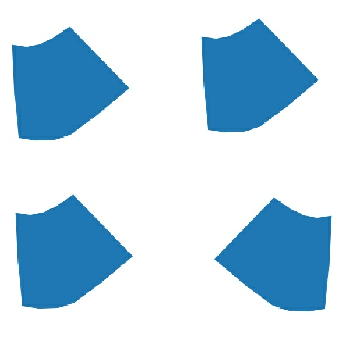

In [11]:
plt.figure(figsize=(6, 6))
for i in range(4):
    rj_inp, rj_re = random_jitter(inp, re)
    plt.subplot(2, 2, i+1)
    plt.imshow(rj_inp/255.0)
    plt.axis('off')
plt.show()

In [12]:
def load_image_train(image_file):
    input_image, real_image = load(image_file)
    input_image, real_image = random_jitter(input_image, real_image)
    input_image, real_image = normalize(input_image, real_image)

    return input_image, real_image

def load_image_test(image_file):
    input_image, real_image = load(image_file)
    input_image, real_image = resize(input_image, real_image,
                                   IMG_HEIGHT, IMG_WIDTH)
    input_image, real_image = normalize(input_image, real_image)

    return input_image, real_image

In [13]:
train_dataset = tf.data.Dataset.list_files(PATH+'train/*.jpg')
train_dataset = train_dataset.map(load_image_train,
                                  num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

In [14]:
test_dataset = tf.data.Dataset.list_files(PATH+'test/*.jpg')
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(BATCH_SIZE)

### Build the Generator

In [15]:
OUTPUT_CHANNELS = 3

In [16]:
def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())

    result.add(tf.keras.layers.LeakyReLU())

    return result

In [17]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

    result.add(tf.keras.layers.BatchNormalization())

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

    result.add(tf.keras.layers.ReLU())

    return result

In [18]:
def Generator():
    inputs = tf.keras.layers.Input(shape=[256,256,3])

    down_stack = [
    downsample(64, 4, apply_batchnorm=False), # (bs, 128, 128, 64)
    downsample(128, 4), # (bs, 64, 64, 128)
    downsample(256, 4), # (bs, 32, 32, 256)
    downsample(512, 4), # (bs, 16, 16, 512)
    downsample(512, 4), # (bs, 8, 8, 512)
    downsample(512, 4), # (bs, 4, 4, 512)
    downsample(512, 4), # (bs, 2, 2, 512)
    downsample(512, 4), # (bs, 1, 1, 512)
    ]

    up_stack = [
    upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
    upsample(512, 4), # (bs, 16, 16, 1024)
    upsample(256, 4), # (bs, 32, 32, 512)
    upsample(128, 4), # (bs, 64, 64, 256)
    upsample(64, 4), # (bs, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh') # (bs, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

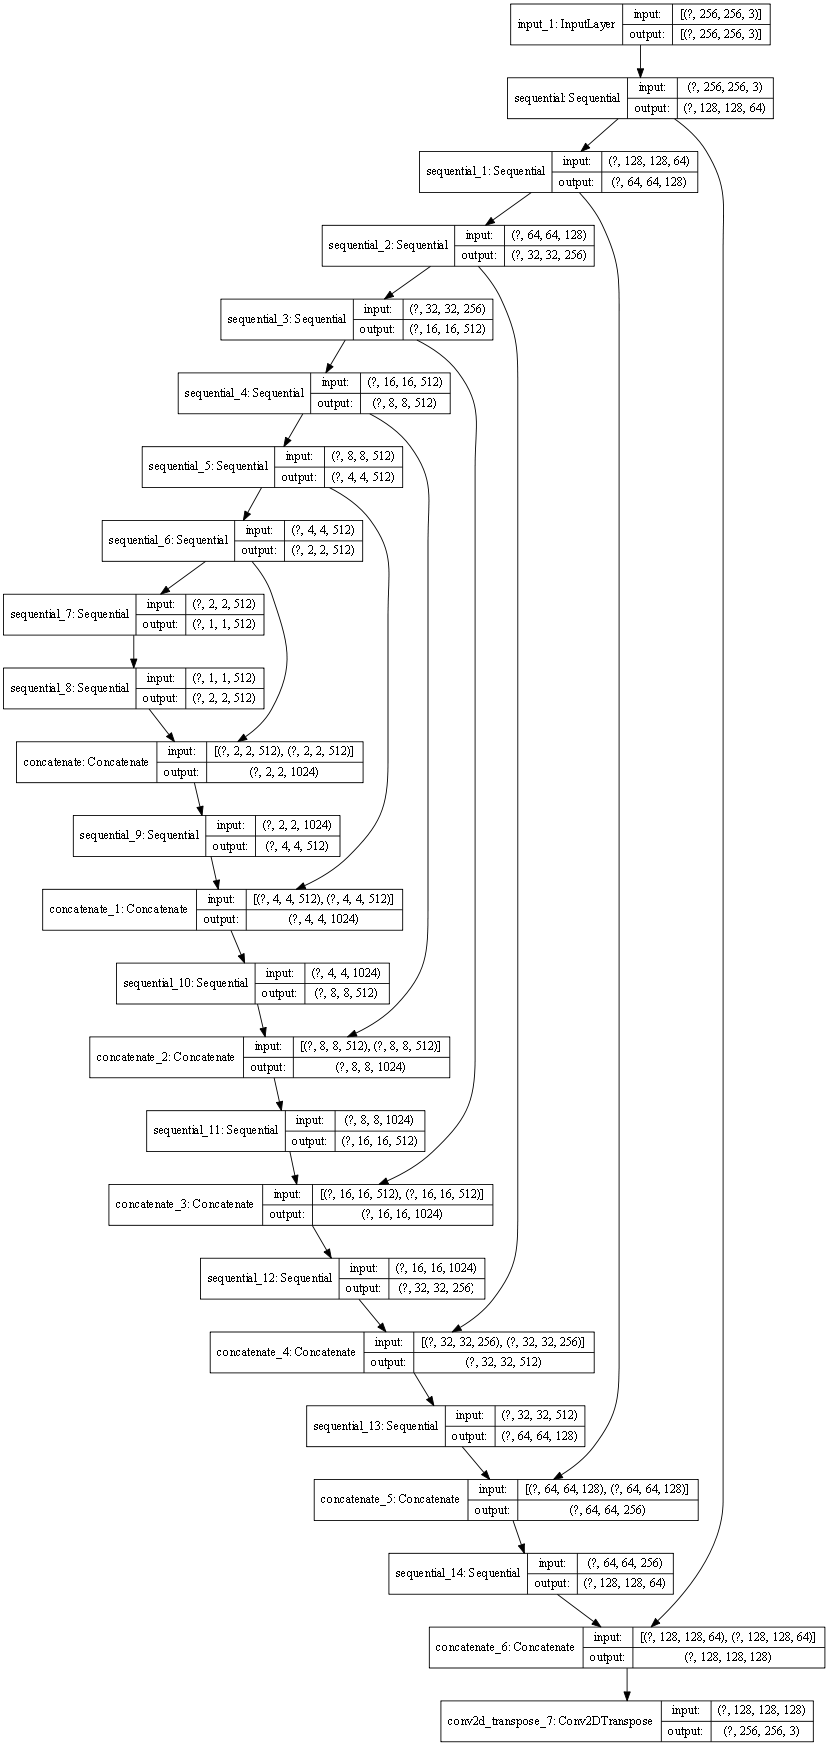

In [19]:
generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

In [20]:
LAMBDA = 100
def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

    # mean absolute error
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

    total_gen_loss = gan_loss + (LAMBDA * l1_loss)

    return total_gen_loss, gan_loss, l1_loss

In [21]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)

    inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
    tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')

    x = tf.keras.layers.concatenate([inp, tar]) # (bs, 256, 256, channels*2)

    down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
    down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
    down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)

    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
    conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

    batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

    leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

    last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

    return tf.keras.Model(inputs=[inp, tar], outputs=last)

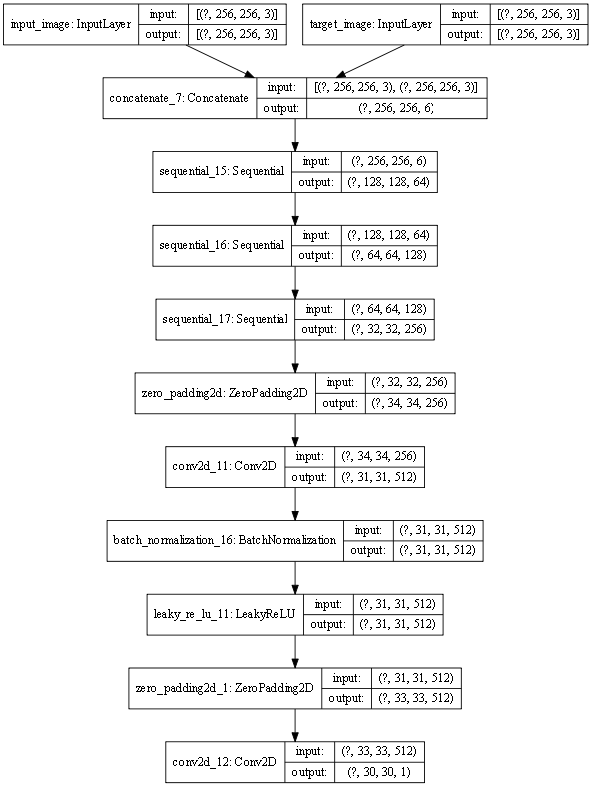

In [22]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


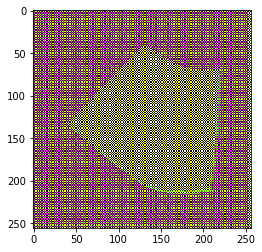

In [23]:
gen_output = generator(inp[tf.newaxis,...], training=False)
plt.imshow(gen_output[0,...])

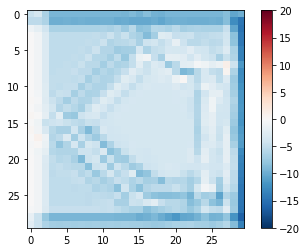

In [24]:
disc_out = discriminator([inp[tf.newaxis,...], gen_output], training=False)
plt.imshow(disc_out[0,...,-1], vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar()

In [25]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

    total_disc_loss = real_loss + generated_loss

    return total_disc_loss

In [43]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

checkpoint_dir = '.\training'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [36]:
def generate_images(model, test_input, tar):
    prediction = model(test_input, training=True)
    plt.figure(figsize=(15,15))

    display_list = [test_input[0], tar[0], prediction[0]]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        # getting the pixel values between [0, 1] to plot it.
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

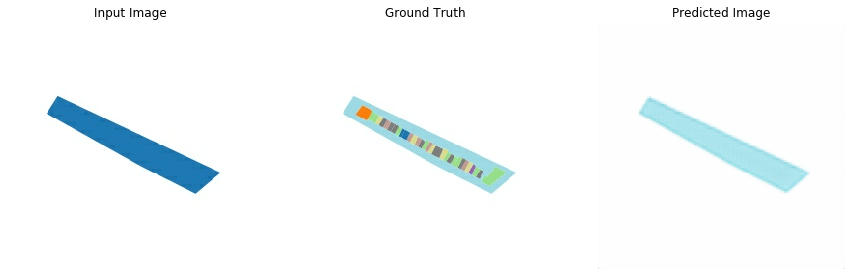

In [37]:
for example_input, example_target in test_dataset.take(1):
    generate_images(generator, example_input, example_target)

In [38]:
EPOCHS = 150

import datetime
log_dir="logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [39]:
@tf.function
def train_step(input_image, target, epoch):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)

        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)

        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    generator_gradients = gen_tape.gradient(gen_total_loss,
                                              generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss,
                                                   discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients,
                                              generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                                  discriminator.trainable_variables))

    with summary_writer.as_default():
        tf.summary.scalar('gen_total_loss', gen_total_loss, step=epoch)
        tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=epoch)
        tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=epoch)
        tf.summary.scalar('disc_loss', disc_loss, step=epoch)

In [40]:
def fit(train_ds, epochs, test_ds):
    for epoch in range(epochs):
        start = time.time()

        display.clear_output(wait=True)

        for example_input, example_target in test_ds.take(1):
            generate_images(generator, example_input, example_target)
        print("Epoch: ", epoch)

            # Train
        for n, (input_image, target) in train_ds.enumerate():
            print('.', end='')
            if (n+1) % 100 == 0:
                print()
            train_step(input_image, target, epoch)
        print()

        # saving (checkpoint) the model every 20 epochs
        if (epoch + 1) % 20 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

        print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                            time.time()-start))
        checkpoint.save(file_prefix = checkpoint_prefix)

In [41]:
!kill 5568
#%load_ext tensorboard
%reload_ext tensorboard
%tensorboard --logdir {log_dir}

'kill' is not recognized as an internal or external command,
operable program or batch file.


Reusing TensorBoard on port 6006 (pid 5568), started 8:49:20 ago. (Use '!kill 5568' to kill it.)

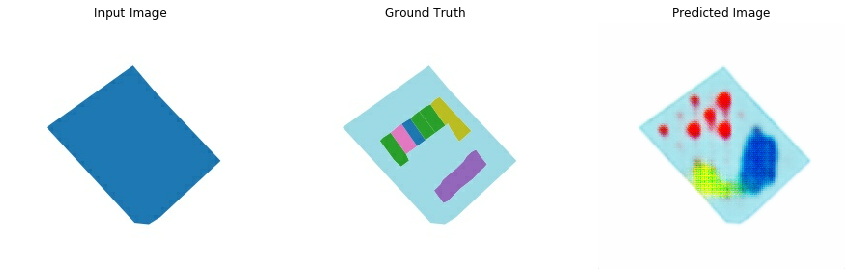

Epoch:  0
....................................................................................................
.........................................
Time taken for epoch 1 is 176.86641573905945 sec



InvalidArgumentError: Failed to create a directory: .	raining; Invalid argument

In [44]:
tf.config.experimental_run_functions_eagerly(True)
fit(train_dataset, EPOCHS, test_dataset)

In [ ]:
# !tensorboard dev upload --logdir  {log_dir}

In [41]:
checkpoint_dir_prev = 'D:\training_checkpoints_old'
!ls {checkpoint_dir}

'ls' is not recognized as an internal or external command,
operable program or batch file.


In [39]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir_prev))

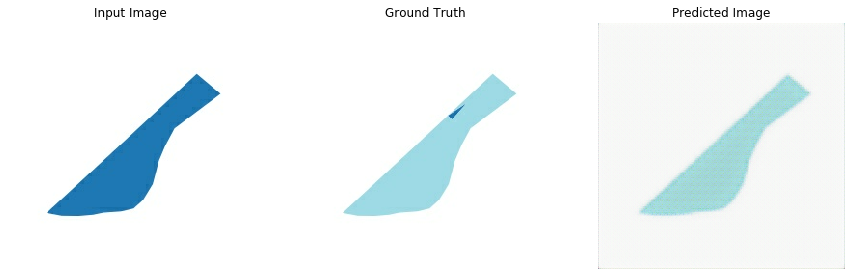

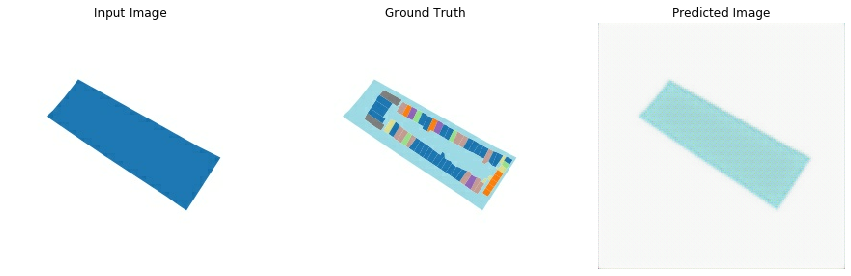

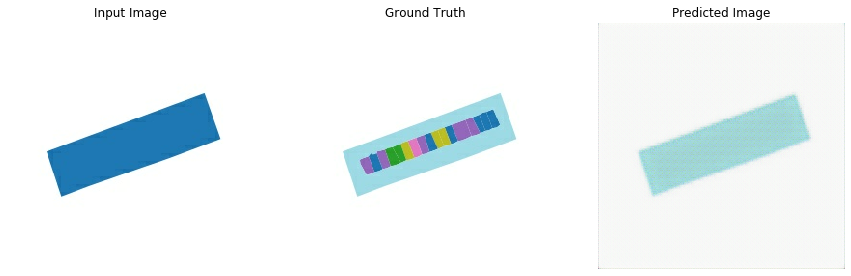

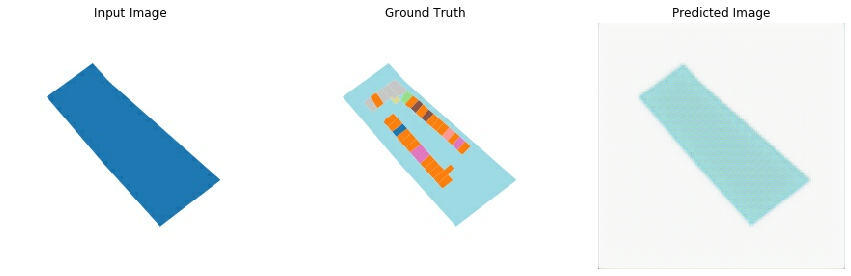

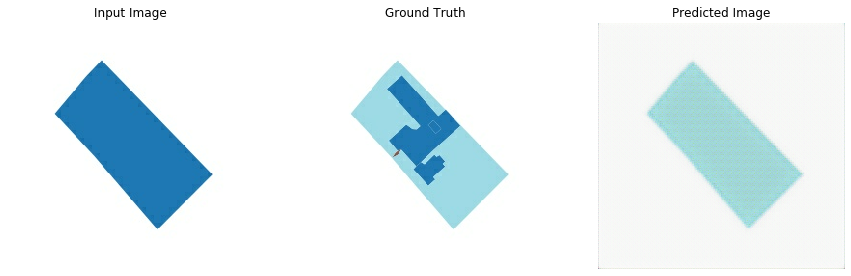

In [40]:
# Run the trained model on a few examples from the test dataset
for inp, tar in test_dataset.take(5):
    generate_images(generator, inp, tar)

In [132]:
generator.save_weights('random_checkpoint')

## Exporter